# Import libraries

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load data

In [16]:
data_dir = Path("../../data/1000G")
chunks_root = os.path.join(data_dir, "chunks")
non_snp_cols = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE']
# We'll add the parsed population info, too:
derived_cols = ['population', 'subpopulation']
non_snp_cols_full = non_snp_cols + derived_cols
pc_range = [1, 2, 3, 4, 5, 10, 30, 50, 100]
#pc_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20]
max_nr_pcs = 1000
pcs_df = pd.read_pickle(f"{data_dir}/pca/1000G_{max_nr_pcs}_PCs.pkl")


In [17]:
"""
FAST VERSION
"""
def impute_inplace(A, fill_for_all_nan=0.0):
    # A is (N,M) float with NaNs
    col_means = np.nanmean(A, axis=0)
    col_means = np.where(np.isnan(col_means), fill_for_all_nan, col_means)
    r, c = np.where(np.isnan(A))
    if r.size:
        A[r, c] = col_means[c]

compare_pcs = pd.DataFrame()
for PC_nr in pc_range:
    print(PC_nr)
    PCS_cols = [f"PC{a+1}" for a in range(PC_nr)]
    pcs_temp = pcs_df[PCS_cols]

    # --- Build X as a NumPy array (N,p) with intercept ---
    X_pc = pcs_temp.to_numpy(dtype=np.float64)              # (N, PC_nr)
    X = np.concatenate([np.ones((X_pc.shape[0], 1)), X_pc], axis=1)  # (N, p=PC_nr+1)

    # Precompute P = (X'X)^(-1) X' using solve (avoids explicit inverse)
    XtX = X.T @ X                                           # (p,p)
    P = np.linalg.solve(XtX, X.T)                           # (p,N)

    F_chroms = []

    for chrom in sorted(os.listdir(chunks_root)):
        print(f"chrom = {chrom}")
        chrom_path = f"{chunks_root}/{chrom}"
        if not os.path.isdir(chrom_path):
            continue

        chunk_files = sorted(f for f in os.listdir(chrom_path) if f.endswith(".pkl"))
        if not chunk_files:
            continue

        F_chunks = []

        for fname in chunk_files:
            path_chunk = f"{chrom_path}/{fname}"
            df = pd.read_pickle(path_chunk)

            snp_cols = [c for c in df.columns if c not in non_snp_cols_full]
            if not snp_cols:
                continue

            # Genotype/het as NumPy
            G = df[snp_cols].to_numpy(dtype=np.float64)                  # (N,M)
            H = (df[snp_cols].to_numpy(dtype=np.float64) == 0.0).astype(np.float64)

            # --- Sanity check: row counts must match between PCs and genotypes
            if X.shape[0] != G.shape[0]:
                raise ValueError(f"Row mismatch: PCs N={X.shape[0]} vs genotypes N={G.shape[0]}")

            # Impute NaNs per column
            impute_inplace(G, fill_for_all_nan=0.0)
            impute_inplace(H, fill_for_all_nan=0.0)

            # Batched OLS predictions (all NumPy → no label alignment)
            BG = P @ G                  # (p,M)
            EG = X @ BG                 # (N,M)

            BH = P @ H                  # (p,M)
            EH = X @ BH                 # (N,M)

            # F-hat
            #p_hat = np.clip((EG + 1.0) / 2.0, 1e-6, 1 - 1e-6)
            #denom = np.clip(2.0 * p_hat * (1.0 - p_hat), 1e-6, None)
            #F_hat = np.clip(1.0 - (EH / denom), 0.0, 1.0)                # (N,M)

            eps_abs = 1e-12          # absolute floor to avoid divide-by-zero
            
            p_hat = (EG + 1.0) / 2.0
            denom = 2.0 * p_hat * (1.0 - p_hat)
            denom_stable = denom + eps_abs
            F_hat = 1.0 - (EH / denom_stable)
            F_chunks.append(F_hat.mean(axis=1))                           # (N,)

        if F_chunks:
            F_mean_per_ind_chr = np.mean(np.column_stack(F_chunks), axis=1)
            F_chroms.append(F_mean_per_ind_chr)

    if F_chroms:
        F_mean_per_ind_per_chrom = np.mean(np.column_stack(F_chroms), axis=1)
    compare_pcs[f"{PC_nr}PCs"] = F_mean_per_ind_per_chrom

1
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
2
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
3
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
4
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
5
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
10
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
30
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
50
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22
100
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22


In [18]:
df = compare_pcs.copy()

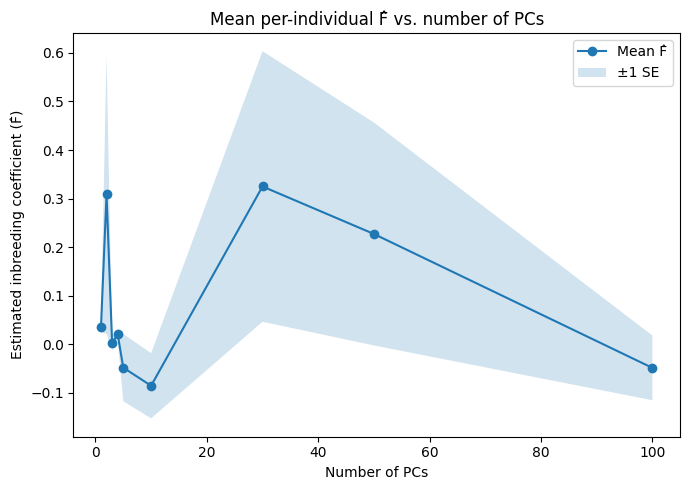

In [19]:
import matplotlib.pyplot as plt

mean_vals = df.mean(axis=0)   # mean per PC
std_vals  = df.std(axis=0)
se_vals   = std_vals / (df.shape[0] ** 0.5)

x = [int(col.replace("PCs","")) for col in df.columns]

plt.figure(figsize=(7,5))
plt.plot(x, mean_vals, marker="o", label="Mean F̂")
plt.fill_between(x, mean_vals - se_vals, mean_vals + se_vals, alpha=0.2, label="±1 SE")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient (F̂)")
plt.title("Mean per-individual F̂ vs. number of PCs")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3719/343561853.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")


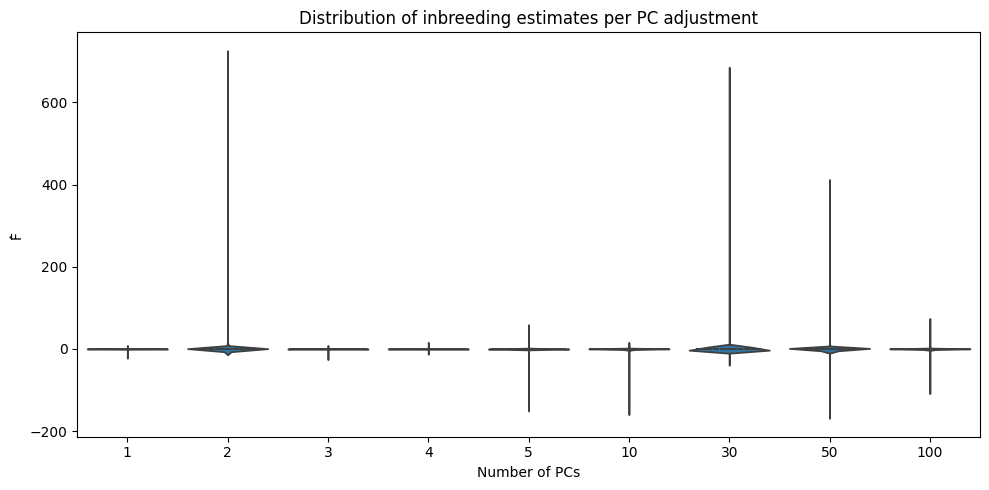

In [20]:
import seaborn as sns

df_long = df.melt(var_name="PCs", value_name="F")
df_long["PCs"] = df_long["PCs"].str.replace("PCs","").astype(int)

plt.figure(figsize=(10,5))
sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Distribution of inbreeding estimates per PC adjustment")
plt.tight_layout()
plt.show()


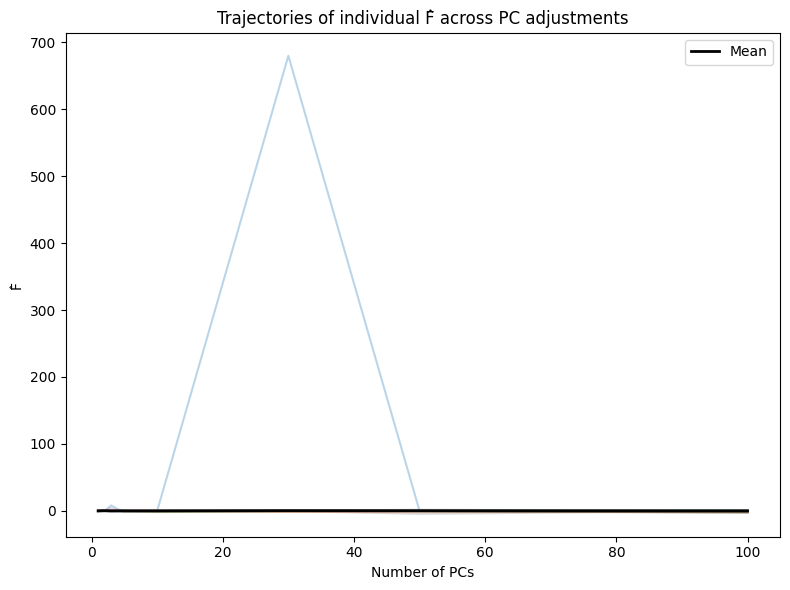

In [21]:
subset = df.sample(n=50, random_state=1)   # random subset of individuals
x = [int(c.replace("PCs","")) for c in df.columns]

plt.figure(figsize=(8,6))
for i, row in subset.iterrows():
    plt.plot(x, row.values, alpha=0.3)

plt.plot(x, df.mean(axis=0), color="black", linewidth=2, label="Mean")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Trajectories of individual F̂ across PC adjustments")
plt.legend()
plt.tight_layout()
plt.show()


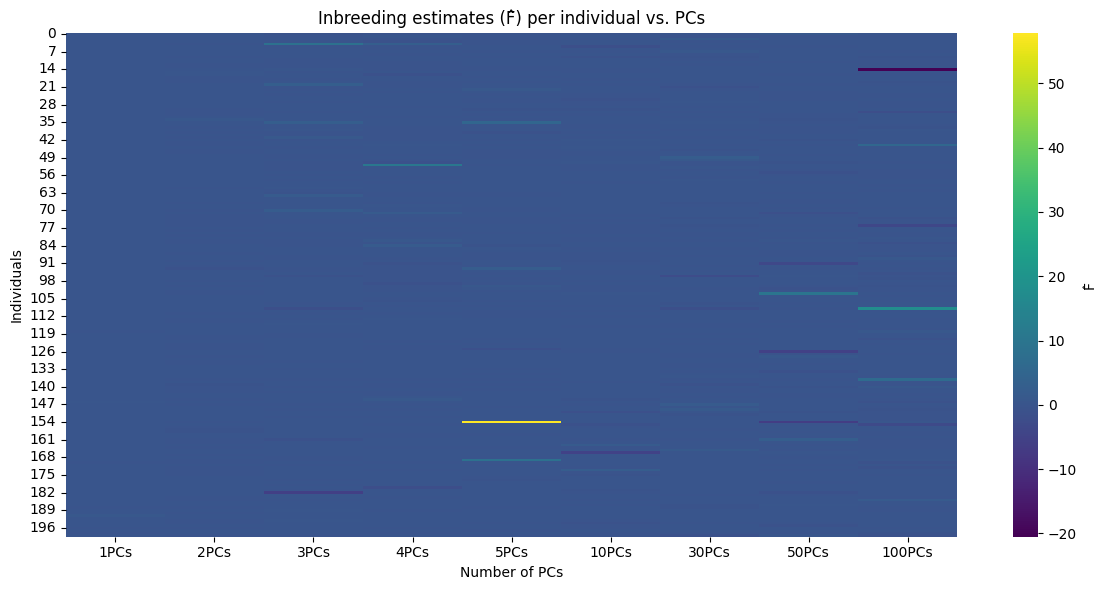

In [22]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df.iloc[:200], cmap="viridis", cbar_kws={'label': 'F̂'})  # first 200 individuals
plt.xlabel("Number of PCs")
plt.ylabel("Individuals")
plt.title("Inbreeding estimates (F̂) per individual vs. PCs")
plt.tight_layout()
plt.show()
